In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
from malaya_speech.train.model.revsic_glowtts import model_stochastic
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)
config.dur_dropout = 0.5

In [7]:
model = model_stochastic.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Sum_6:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [9]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
parameters = {
    'optimizer_params': {'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-9},
    'lr_policy_params': {
        'warmup_steps': 40000,
    },
}

def noam_schedule(step, learning_rate, channels, warmup_steps=4000):
    return learning_rate * channels ** -0.5 * \
            tf.minimum(step ** -0.5, step * warmup_steps ** -1.5)

def learning_rate_scheduler(global_step):
    return transformer_schedule(
        tf.cast(global_step, tf.float32),
        config.channels,
        **parameters['lr_policy_params'],
    )

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [16]:
%%time

o = sess.run(mel, feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 604 ms, sys: 142 ms, total: 746 ms
Wall time: 174 ms


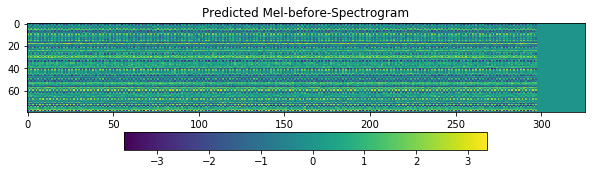

In [17]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [18]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 907 ms, sys: 176 ms, total: 1.08 s
Wall time: 249 ms


In [19]:
for k in range(100):
    o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})
    print(k, o)

0 [2.6747499, {'nll': 1.0570581, 'durloss': 1.6176918, 'mel_': array([[[-1.3222847 , -5.302875  , -0.32945353, ..., -2.922039  ,
         -0.6525099 , -3.0864248 ],
        [-4.029194  , -6.1638365 , -3.8038034 , ..., -3.2717967 ,
         -2.3476813 , -3.433086  ],
        [-1.1147304 , -5.155427  , -0.48440996, ..., -2.788229  ,
         -0.50721455, -2.951782  ],
        ...,
        [-3.7329514 , -6.2314205 , -3.7329514 , ..., -6.2314205 ,
         -3.7329514 , -6.2314205 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.3222847 , -5.302875  , -0.32945353, ..., -2.922039  ,
         -0.6525099 , -3.0864248 ],
        [-4.029194  , -6.1638365 , -3.8038034 , ..., -3.2717967 ,
         -2.3476813 , -3.433086  ],
        [-1.1147304 , -5.155427  , -0.48440996, ..., -2.788229  ,
         -0.50721455, -2.951782  ],
    

7 [2.1472464, {'nll': 0.4742359, 'durloss': 1.6730103, 'mel_': array([[[-0.17140603, -3.7764363 ,  0.6607314 , ..., -1.7561008 ,
         -0.02433893, -1.9487897 ],
        [-2.2256234 , -3.7720044 , -1.8668723 , ..., -2.11071   ,
         -1.1093087 , -2.1812282 ],
        [-0.06540096, -3.6370711 ,  0.39454418, ..., -1.6299833 ,
          0.0047349 , -1.8630965 ],
        ...,
        [-1.3048226 , -3.1265934 , -1.1371671 , ..., -3.4730644 ,
         -1.1028527 , -3.4409823 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[-0.17140603, -3.7764363 ,  0.6607314 , ..., -1.7561008 ,
         -0.02433893, -1.9487897 ],
        [-2.2256234 , -3.7720044 , -1.8668723 , ..., -2.11071   ,
         -1.1093087 , -2.1812282 ],
        [-0.06540096, -3.6370711 ,  0.39454418, ..., -1.6299833 ,
          0.0047349 , -1.8630965 ],
    

14 [1.4542133, {'nll': 0.21343517, 'durloss': 1.2407781, 'mel_': array([[[ 0.5055269 , -1.8995489 ,  1.1701488 , ..., -0.56549054,
          0.2528938 , -0.64628446],
        [-0.41521382, -1.6267627 , -0.08102865, ..., -0.95842946,
         -0.05004068, -1.0217874 ],
        [ 0.55882704, -1.7611846 ,  0.82465374, ..., -0.44791174,
          0.22703926, -0.61994326],
        ...,
        [ 0.67916423, -1.0158958 ,  0.7162039 , ..., -1.5392487 ,
          0.649703  , -1.6239653 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.5055269 , -1.8995489 ,  1.1701488 , ..., -0.56549054,
          0.2528938 , -0.64628446],
        [-0.41521382, -1.6267627 , -0.08102865, ..., -0.95842946,
         -0.05004068, -1.0217874 ],
        [ 0.55882704, -1.7611846 ,  0.82465374, ..., -0.44791174,
          0.22703926, -0.61994326],
  

20 [1.2517239, {'nll': -0.04353593, 'durloss': 1.2952598, 'mel_': array([[[ 0.3383558 , -1.2174008 ,  1.0672389 , ..., -0.20618628,
          0.11692727,  0.01910327],
        [-0.19662705, -0.79604506,  0.11122201, ..., -0.66833806,
         -0.06149787, -0.8480268 ],
        [ 0.34829104, -1.1607487 ,  0.55578196, ..., -0.09718945,
          0.01260553, -0.02428505],
        ...,
        [ 0.99081767, -0.2542928 ,  0.97956645, ..., -1.3697565 ,
          0.6839119 , -1.6666431 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.3383558 , -1.2174008 ,  1.0672389 , ..., -0.20618628,
          0.11692727,  0.01910327],
        [-0.19662705, -0.79604506,  0.11122201, ..., -0.66833806,
         -0.06149787, -0.8480268 ],
        [ 0.34829104, -1.1607487 ,  0.55578196, ..., -0.09718945,
          0.01260553, -0.02428505],
 

26 [1.1878227, {'nll': -0.31318843, 'durloss': 1.5010111, 'mel_': array([[[ 3.6860794e-01, -1.1327940e+00,  1.7398286e+00, ...,
         -1.6705938e-01, -4.4314831e-02,  5.7344419e-01],
        [-5.2619284e-01, -2.0795898e-01, -2.2831145e-01, ...,
         -9.9889648e-01, -6.0025954e-01, -1.2258292e+00],
        [ 3.2112032e-01, -1.3127484e+00,  6.9358361e-01, ...,
         -2.3454428e-03, -2.8516179e-01,  4.1644204e-01],
        ...,
        [ 8.8413978e-01,  5.2015078e-01,  8.6843139e-01, ...,
         -2.2665555e+00, -1.8343017e-01, -2.5860975e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -0.0000000e+00,  0.0000000e+00, -0.0000000e+00]],

       [[ 3.6860794e-01, -1.1327940e+00,  1.7398286e+00, ...,
         -1.6705938e-01, -4.4314831e-02,  5.7344419e-01],
        [-5.2619284e-01, -2.0795898e-01, -2.2831145e-01, ...,
         -9.98896

32 [1.079664, {'nll': -0.47623652, 'durloss': 1.5559006, 'mel_': array([[[ 0.8146733 , -1.4336659 ,  2.33326   , ...,  0.01169831,
          0.36177215,  0.08147295],
        [-0.36989313,  0.35303995, -0.5927353 , ..., -1.0066103 ,
         -0.61766666, -0.58651304],
        [ 0.63405716, -2.2164104 ,  0.8038926 , ...,  0.1623837 ,
         -0.03060555, -0.55793273],
        ...,
        [ 0.9968158 ,  0.9879531 ,  0.5413798 , ..., -2.6047964 ,
         -0.14003928, -1.7288909 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.8146733 , -1.4336659 ,  2.33326   , ...,  0.01169831,
          0.36177215,  0.08147295],
        [-0.36989313,  0.35303995, -0.5927353 , ..., -1.0066103 ,
         -0.61766666, -0.58651304],
        [ 0.63405716, -2.2164104 ,  0.8038926 , ...,  0.1623837 ,
         -0.03060555, -0.55793273],
  

39 [0.7060629, {'nll': -0.59614503, 'durloss': 1.302208, 'mel_': array([[[ 0.866689  , -0.13588884,  1.7838147 , ...,  0.12514073,
          0.17015365,  0.4721332 ],
        [-1.3805221 , -1.1123439 , -1.848999  , ..., -1.0174803 ,
         -1.3566257 , -0.8661747 ],
        [ 0.61403847, -0.7494091 ,  0.17845455, ...,  0.60450155,
         -0.17798132, -0.23704317],
        ...,
        [ 1.2213179 , -0.69220895,  0.1735222 , ..., -2.2514758 ,
         -0.80647886, -2.3162282 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.866689  , -0.13588884,  1.7838147 , ...,  0.12514073,
          0.17015365,  0.4721332 ],
        [-1.3805221 , -1.1123439 , -1.848999  , ..., -1.0174803 ,
         -1.3566257 , -0.8661747 ],
        [ 0.61403847, -0.7494091 ,  0.17845455, ...,  0.60450155,
         -0.17798132, -0.23704317],
  

45 [0.68222034, {'nll': -0.66966, 'durloss': 1.3518803, 'mel_': array([[[ 0.7379358 , -0.2952756 ,  2.5772762 , ..., -0.24583572,
         -0.20347996,  0.06382417],
        [-1.5821668 , -1.1872671 , -0.91601384, ..., -0.61726445,
         -1.0737482 , -0.08256118],
        [ 0.5573407 , -0.9254402 ,  0.55949724, ...,  0.42398572,
         -0.51735085, -0.76072806],
        ...,
        [ 0.39034402, -0.6044999 ,  0.5497201 , ..., -1.4327428 ,
         -0.30944383, -0.85636944],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.7379358 , -0.2952756 ,  2.5772762 , ..., -0.24583572,
         -0.20347996,  0.06382417],
        [-1.5821668 , -1.1872671 , -0.91601384, ..., -0.61726445,
         -1.0737482 , -0.08256118],
        [ 0.5573407 , -0.9254402 ,  0.55949724, ...,  0.42398572,
         -0.51735085, -0.76072806],
   

51 [0.78202176, {'nll': -0.7213664, 'durloss': 1.5033882, 'mel_': array([[[ 0.54802257, -0.6868053 ,  2.5759335 , ..., -0.03189364,
          0.06869411,  0.26362938],
        [-1.7775159 , -1.0262244 , -1.0969065 , ..., -0.84088546,
         -0.89148647, -0.353799  ],
        [ 0.48083323, -1.0378982 ,  0.64273983, ...,  0.8854926 ,
         -0.21716185, -0.4075229 ],
        ...,
        [ 1.5364609 , -0.3937767 ,  0.8053652 , ..., -2.3107958 ,
          0.805662  , -1.7598094 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.54802257, -0.6868053 ,  2.5759335 , ..., -0.03189364,
          0.06869411,  0.26362938],
        [-1.7775159 , -1.0262244 , -1.0969065 , ..., -0.84088546,
         -0.89148647, -0.353799  ],
        [ 0.48083323, -1.0378982 ,  0.64273983, ...,  0.8854926 ,
         -0.21716185, -0.4075229 ],
 

58 [0.5308082, {'nll': -0.7766831, 'durloss': 1.3074913, 'mel_': array([[[-0.27396584, -0.30342215,  2.2706685 , ...,  0.11951035,
          0.26142943,  0.30399   ],
        [-2.6676784 , -1.1343993 , -0.7588159 , ..., -1.0623184 ,
         -1.1117857 , -0.41720828],
        [-0.33448398, -0.4972539 ,  0.44954243, ...,  1.2115873 ,
         -0.12969832, -0.32704312],
        ...,
        [ 0.06394038, -0.14593378,  0.3564688 , ..., -2.2511187 ,
         -0.14781213, -1.9893883 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[-0.27396584, -0.30342215,  2.2706685 , ...,  0.11951035,
          0.26142943,  0.30399   ],
        [-2.6676784 , -1.1343993 , -0.7588159 , ..., -1.0623184 ,
         -1.1117857 , -0.41720828],
        [-0.33448398, -0.4972539 ,  0.44954243, ...,  1.2115873 ,
         -0.12969832, -0.32704312],
  

65 [0.40710258, {'nll': -0.8322135, 'durloss': 1.2393161, 'mel_': array([[[-0.21922408, -0.39122036,  2.2330868 , ...,  0.0381276 ,
          0.2599485 , -0.0592476 ],
        [-2.0085053 , -0.9669918 , -0.5492245 , ..., -0.6438002 ,
         -0.8241269 , -0.01067366],
        [-0.5943396 , -0.37482417,  0.1887404 , ...,  1.0884354 ,
         -0.33357   , -0.58190566],
        ...,
        [ 0.19226956,  0.15136334,  0.32299653, ..., -1.6786625 ,
          0.17079997, -1.6222341 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[-0.21922408, -0.39122036,  2.2330868 , ...,  0.0381276 ,
          0.2599485 , -0.0592476 ],
        [-2.0085053 , -0.9669918 , -0.5492245 , ..., -0.6438002 ,
         -0.8241269 , -0.01067366],
        [-0.5943396 , -0.37482417,  0.1887404 , ...,  1.0884354 ,
         -0.33357   , -0.58190566],
 

71 [0.5452101, {'nll': -0.8701327, 'durloss': 1.4153428, 'mel_': array([[[-0.14684618, -0.03885406,  2.3459942 , ...,  0.30414712,
          0.21710163,  0.53991276],
        [-3.005971  , -1.1030769 , -0.8601898 , ..., -0.8834323 ,
         -1.2730626 , -0.3009475 ],
        [-0.5729201 , -0.13535099,  0.14086321, ...,  1.2568562 ,
         -0.54520154, -0.18095253],
        ...,
        [ 0.15239555,  0.28587708, -0.1732223 , ..., -2.3754551 ,
         -0.22082697, -2.4731016 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[-0.14684618, -0.03885406,  2.3459942 , ...,  0.30414712,
          0.21710163,  0.53991276],
        [-3.005971  , -1.1030769 , -0.8601898 , ..., -0.8834323 ,
         -1.2730626 , -0.3009475 ],
        [-0.5729201 , -0.13535099,  0.14086321, ...,  1.2568562 ,
         -0.54520154, -0.18095253],
  

78 [0.36443317, {'nll': -0.91534114, 'durloss': 1.2797743, 'mel_': array([[[ 0.3122566 , -0.41435313,  2.7928503 , ...,  0.6494154 ,
          0.61160326,  0.3773799 ],
        [-2.0550678 , -0.96896607, -0.574067  , ..., -0.7146655 ,
         -0.96330863, -0.02521684],
        [-0.02543314, -0.5909659 ,  0.61396426, ...,  1.5174582 ,
         -0.29420835, -0.57533413],
        ...,
        [ 1.3729346 ,  0.5479412 ,  0.63621974, ..., -2.5642545 ,
         -0.01353243, -2.0720315 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.3122566 , -0.41435313,  2.7928503 , ...,  0.6494154 ,
          0.61160326,  0.3773799 ],
        [-2.0550678 , -0.96896607, -0.574067  , ..., -0.7146655 ,
         -0.96330863, -0.02521684],
        [-0.02543314, -0.5909659 ,  0.61396426, ...,  1.5174582 ,
         -0.29420835, -0.57533413],


84 [0.54599667, {'nll': -0.95741713, 'durloss': 1.5034138, 'mel_': array([[[ 0.03592789, -0.1934094 ,  2.9105833 , ...,  0.95119005,
          0.63512063,  0.4860594 ],
        [-2.94237   , -0.952024  , -0.10845844, ..., -0.9238047 ,
         -1.4995816 , -0.00462756],
        [-0.3791437 , -0.166632  ,  0.7952933 , ...,  1.6829299 ,
         -0.28375208, -0.72471297],
        ...,
        [ 0.82376295,  0.5842998 ,  0.795722  , ..., -3.056897  ,
         -0.9896855 , -1.885263  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.03592789, -0.1934094 ,  2.9105833 , ...,  0.95119005,
          0.63512063,  0.4860594 ],
        [-2.94237   , -0.952024  , -0.10845844, ..., -0.9238047 ,
         -1.4995816 , -0.00462756],
        [-0.3791437 , -0.166632  ,  0.7952933 , ...,  1.6829299 ,
         -0.28375208, -0.72471297],


91 [0.42311984, {'nll': -0.9970426, 'durloss': 1.4201624, 'mel_': array([[[ 0.03335036, -0.335735  ,  2.5920525 , ...,  1.0677261 ,
          0.54235715,  0.3127795 ],
        [-2.474645  , -0.99067914, -0.28518027, ..., -0.4699107 ,
         -1.386656  ,  0.16303056],
        [-0.2286233 , -0.4126275 ,  0.618872  , ...,  1.3871791 ,
         -0.4787253 , -1.3512423 ],
        ...,
        [ 0.6355666 ,  0.5079795 , -0.03981236, ..., -1.8077837 ,
         -1.0390301 , -1.4017739 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.03335036, -0.335735  ,  2.5920525 , ...,  1.0677261 ,
          0.54235715,  0.3127795 ],
        [-2.474645  , -0.99067914, -0.28518027, ..., -0.4699107 ,
         -1.386656  ,  0.16303056],
        [-0.2286233 , -0.4126275 ,  0.618872  , ...,  1.3871791 ,
         -0.4787253 , -1.3512423 ],
 

97 [0.10744119, {'nll': -1.0436878, 'durloss': 1.151129, 'mel_': array([[[ 0.6561997 , -0.80733055,  2.610043  , ...,  1.527462  ,
          0.7665559 ,  0.21867093],
        [-2.396207  , -0.7541237 , -0.3943937 , ..., -0.49439996,
         -1.4541868 ,  0.247534  ],
        [ 0.35040447, -0.9188173 ,  0.66463274, ...,  1.5539153 ,
         -0.2719772 , -1.679021  ],
        ...,
        [ 0.19541258,  0.6010737 ,  0.27341914, ..., -2.1945586 ,
         -1.1442686 , -1.4638671 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 0.6561997 , -0.80733055,  2.610043  , ...,  1.527462  ,
          0.7665559 ,  0.21867093],
        [-2.396207  , -0.7541237 , -0.3943937 , ..., -0.49439996,
         -1.4541868 ,  0.247534  ],
        [ 0.35040447, -0.9188173 ,  0.66463274, ...,  1.5539153 ,
         -0.2719772 , -1.679021  ],
  

In [20]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 904 ms, sys: 185 ms, total: 1.09 s
Wall time: 257 ms


In [21]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                        mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

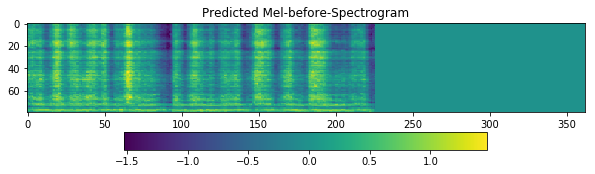

In [22]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

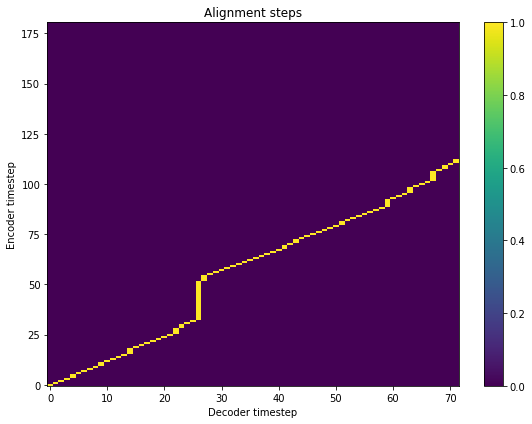

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [21]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'